# Load and viz

[  7   0  84 185 159 151  60  36 222 254 241 198 170  52  67 114  72 163
 227 225 250 229 140  17  66  14  59  21 236 106  83 253 209  18  22 233
 255 129 238  44 249  62 133 187   5   9 205 248  58 126 182  75 251 240
  57  19 221 166   3 203 219  35  38  77  31 224 115   1  61 242 121  40
 207]


,y,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


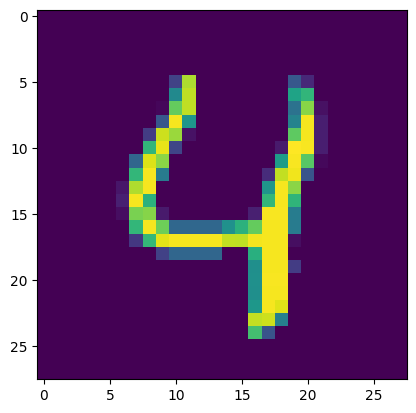

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('data_tp1.csv',header=None)
data = data.rename(columns={0:'y'})
print(data.iloc[0,:].unique())

imsize = round(np.sqrt(784)+1)
linha_y = 4
img = np.reshape(data.iloc[linha_y,1:].values, (imsize-1,imsize-1))
plt.imshow(img)

data.head(2)

# Def data and model shape

In [3]:
from torch.utils.data import DataLoader, Dataset
import torch

from sklearn.model_selection import train_test_split

y = data.y.values
X = data.drop(columns='y').values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

print(X_train.shape)
print(y_train.shape)
idx = 0
print((X_train[idx,:]).shape)
print(y_train[idx])
(y_train[idx]).shape 

# Pytorch exige que seja utilizado um dataset por algum motivo aparentemente
class custom_mnist_dataset():
    def __init__(self, X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Restrições de uso do pytorch: (leia os docs...)
        # inputs tem que ser float para multiplicar pelos pesos, 
        # outputs tem que ser longint para calcular crossentropy 
        return torch.tensor(self.X[idx,:], dtype=torch.float), self.y[idx]

training_data = custom_mnist_dataset(X = X_train, y = y_train)
test_data = custom_mnist_dataset(X = X_test, y = y_test)

# batch_size de exemplo para teste
batch_size = 25

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape, type: X: {X.shape} {X.dtype}")
    print(f"Shape, type: y: {y.shape} {y.dtype}")
    break
    

(3350, 784)
(3350,)
(784,)
7
Shape, type: X: torch.Size([25, 784]) torch.float32
Shape, type: y: torch.Size([25]) torch.int64


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
from torch import nn
import torch.nn.functional as F

"""
NeuralNetwork with  ...
"""
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(NeuralNetwork, self).__init__()

        self.entrada = nn.Linear(input_size, hidden_dim)
        self.oculta = nn.Linear(hidden_dim, hidden_dim)
        self.saida = nn.Linear(hidden_dim, output_size)

    def forward(self, input):

        x1 = self.entrada(input)
        x2 = F.sigmoid(self.oculta(x1))
        x3 = self.saida(x2)

        return x3
    
# hidden dim = 25,50,100
print(NeuralNetwork(input_size = X_train.shape[1], hidden_dim= 25, output_size=10).to(device))


NeuralNetwork(
  (entrada): Linear(in_features=784, out_features=25, bias=True)
  (oculta): Linear(in_features=25, out_features=25, bias=True)
  (saida): Linear(in_features=25, out_features=10, bias=True)
)


# Def train, test and eval method

In [6]:
# https://www.kaggle.com/code/shrutimechlearn/pytorch-custom-model-step-by-step

def train_step(model, loss_func, optimizer, dataloader):
    
    # to capture loss
    train_loss = 0 

    # to get the model in training mode
    model.train()
    
    for batch, (x_batch, y_batch) in enumerate(dataloader):
        # sending data to the device where rest of the artifacts are
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # forward pass/model prediction with the given input
        y_pred = model(x_batch)
        
        # loss calculation by comparison between predicted and ground truth values
        loss = loss_func(y_pred, y_batch)
        train_loss += loss.item()
    
        # setting previously collected gradient values in the optimizer to zero so it translates only current gradients
        optimizer.zero_grad()
        
        # calculate the gradients for this iteration (independent gradients because previous values have been reset to 0)
        loss.backward()
        
        # update the weights and biases based on the calculated gradients ~(wi = wi + delta_wi)
        optimizer.step()

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)

    return train_loss

In [7]:
def test_step(model, loss_func, test_dataloader):
    
    test_loss = 0
    
    model.eval()
    
    
    with torch.inference_mode():
        
        for batch, (x_batch, y_batch) in enumerate(test_dataloader):
            
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            
            loss = loss_func(y_pred, y_batch)
            test_loss+= loss.item()

    test_loss = test_loss/len(test_dataloader)   

    return test_loss
            

In [8]:
import mlflow
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch import optim

def eval_step_with_mlflowlogging(model,test_dataloader):
        
    with torch.no_grad():
        model.eval()
        total_preds = []
        total_labels = []
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            total_preds.extend(preds.cpu().numpy())
            total_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(total_labels, total_preds)
    precision = precision_score(total_labels, total_preds, average='weighted', labels=np.unique(total_preds))
    recall = recall_score(total_labels, total_preds, average='weighted', labels=np.unique(total_preds))
    f1 = f1_score(total_labels, total_preds, average='weighted', labels=np.unique(total_preds))

    return accuracy, precision, recall, f1

def train_with_mlflowlogging(model, loss_func, optimizer, train_dataloader, test_dataloader, n_epochs, i,lr,hds,bs):
    with mlflow.start_run(run_name=f"Test #{i} - lr({lr}) hds({hds}) bs({bs})", nested = True):  # Name each run based on the learning rate
        mlflow.log_param("batch_size", bs)
        mlflow.log_param("hidden_dim", hds)
        mlflow.log_param("lr", lr)
        
        train_loss = []
        test_loss = []
    
        for epoch in range(n_epochs):
            
            tr_loss = train_step(model, loss_func, optimizer, train_dataloader)
            train_loss.append(tr_loss)
        
            ts_loss = test_step(model, loss_func, test_dataloader)
            test_loss.append(ts_loss)    

            accuracy, precision, recall, f1 = eval_step_with_mlflowlogging(model, test_dataloader)
            
            mlflow.log_metric("loss", tr_loss, step = epoch)
            mlflow.log_metric("val_loss", ts_loss, step = epoch)
            mlflow.log_metric("diff_loss_tr_ts", tr_loss-ts_loss, step = epoch)

            mlflow.log_metric("loss", tr_loss, step = epoch)
            mlflow.log_metric("val_loss", ts_loss, step = epoch)

            mlflow.log_metric("accuracy", accuracy, step = epoch)
            mlflow.log_metric("precision", precision, step = epoch)
            mlflow.log_metric("recall", recall, step = epoch)
            mlflow.log_metric("f1", f1, step = epoch)   

    return train_loss, test_loss


# Def automated trials and logging

In [9]:
# Set up MLflow tracking URI
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.autolog()

2024/06/05 18:54:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/06/05 18:54:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [10]:
# # Example of starting an MLflow run and integrating Optuna for hyperparameter tuning
# with mlflow.start_run():
#     def objective(trial):
#         # Use trial.suggest_* methods to suggest hyperparameters
#         # batch_size = 10,50,len(training_data)
#         batch_size = len(training_data)
        
#         # hidden dim = 25,50,100
#         hidden_dim =100

#         # GB, SGD batch 1, SGD minibatch 10 e 50
#         # lr = 0.5, 1, 10
#         lr = 0.5

#         # Log params
#         mlflow.log_param("batch_size", batch_size)
#         mlflow.log_param("hidden_dim", hidden_dim)
#         mlflow.log_param("lr", lr)

#         # Define your model here
#         train_dataloader = DataLoader(training_data, batch_size=batch_size)
#         test_dataloader = DataLoader(test_data, batch_size=batch_size)

#         model = NeuralNetwork(input_size = X_train.shape[1], hidden_dim= hidden_dim, output_size=10).to(device)

#         loss_func = nn.CrossEntropyLoss()
        
#         optimizer = optim.SGD(model.parameters(), lr=lr)

#         train_loss, test_loss = train_with_mlflowlogging(
#             model, 
#             loss_func, 
#             optimizer, 
#             train_dataloader, 
#             test_dataloader, 
#             n_epochs= 20)

#         # mlflow.log_metric("loss", train_loss[-1])
#         # mlflow.log_metric("val_loss", test_loss[-1])

#         return  test_loss[-1]  # Return a value to minimize (e.g., negative accuracy)

#     study = optuna.create_study(direction="minimize", study_name = "testing_mlflow_optuna_2", load_if_exists = True)
#     study.optimize(objective, n_trials=10)
    
#     # Log the best parameters and other relevant information
#     mlflow.log_params(study.best_params)
#     mlflow.log_metric("best_loss", study.best_value)

In [11]:
# learning_rates = [0.5, 1, 10]
# hidden_dim_sizes = [25, 50, 100]
# batch_sizes = [10, 50, len(training_data)]

# mlflow_exp = mlflow.set_experiment(experiment_name  = 'TP1ML_automation_test')

# with mlflow.start_run(run_name="Test Experiment 1", experiment_id = mlflow_exp.experiment_id):

#     for i_lr, lr in enumerate(learning_rates, start=1):
#         for i_hds, hds in enumerate(hidden_dim_sizes, start = 1):
#             for i_bs, bs in enumerate(batch_sizes, start = 1):
                
#                 # Define your model here
#                 train_dataloader = DataLoader(training_data, batch_size=bs)
#                 test_dataloader = DataLoader(test_data, batch_size=bs)

#                 model = NeuralNetwork(input_size = X_train.shape[1], hidden_dim= hds, output_size=10).to(device)

#                 loss_func = nn.CrossEntropyLoss()
                
#                 optimizer = optim.SGD(model.parameters(), lr=lr)

#                 train_loss, test_loss = train_with_mlflowlogging(
#                     model, 
#                     loss_func, 
#                     optimizer, 
#                     train_dataloader, 
#                     test_dataloader, 
#                     n_epochs= 200,
#                     i=i_lr+i_hds+i_bs,
#                     lr=lr,hds=hds,bs=bs
#                 )
    
            

In [12]:
# learning_rates = [0.5, 1, 10]
# hidden_dim_sizes = [25, 50, 100]
# batch_sizes = [1, 10, 50, len(training_data)]

# mlflow_exp = mlflow.set_experiment(experiment_name  = 'TP1ML_automation_test')

# with mlflow.start_run(run_name="Test Experiment 2", experiment_id = mlflow_exp.experiment_id):
    
#     for i_hds, hds in enumerate(hidden_dim_sizes, start = 1):
#         for i_bs, bs in enumerate(batch_sizes, start = 1):
#             for i_lr, lr in enumerate(learning_rates, start=1):
                
#                 # Define your model here
#                 train_dataloader = DataLoader(training_data, batch_size=bs)
#                 test_dataloader = DataLoader(test_data, batch_size=bs)

#                 model = NeuralNetwork(input_size = X_train.shape[1], hidden_dim= hds, output_size=10).to(device)

#                 loss_func = nn.CrossEntropyLoss()
                
#                 optimizer = optim.SGD(model.parameters(), lr=lr)

#                 train_loss, test_loss = train_with_mlflowlogging(
#                     model, 
#                     loss_func, 
#                     optimizer, 
#                     train_dataloader, 
#                     test_dataloader, 
#                     n_epochs= 20,
#                     i=i_lr+i_hds+i_bs,
#                     lr=lr,hds=hds,bs=bs
#                 )
    
            

KeyboardInterrupt: 

In [ ]:
# Specify the run name you're searching for
run_name = "Test Experiment 3"

# Search for the run by name
runs_df = mlflow.search_runs(filter_string=f"run_name='{run_name}'")

# Get the run ID(s) of the matching run(s)
run_ids = runs_df['run_id'].tolist()

print(f"Found run IDs: {run_ids}")

# Replace 'your_parent_run_id' with the actual parent run ID
parent_run_id = run_ids[0]

# Construct the filter string to search for child runs of the parent run
filter_string = f"tags.mlflow.parentRunId='{parent_run_id}'"

# Search for the child runs
child_runs_df = mlflow.search_runs(filter_string=filter_string)

# Extract the run IDs of the child runs
child_run_ids = child_runs_df['run_id'].tolist()

print(f"Child run IDs: {child_run_ids}")

Found run IDs: ['b5198fcd7e244c4fa1df5d4273af6a07']
Child run IDs: ['a51f555a9bdc4a18a9512e739d81a416', '830acb052ffa4cde92362a298e28a4af', 'ae2474881cc54f2fad467b5d57c1ba47', '853af11fa4ba4452af718367ad079e74', '4b8f4525745b4ff8ad24412629e88eab', '55d8984d6df14d8bb086018106f5a5c4', '0649eb33e2db4358b9f4c94bcb59235f', 'bb9fdb2f94544b24969699dfca0c7df1', 'c2ed5249e1794c7abfff01eafa08135c', 'f34b8fe2fe0a4828ac1176c9561f3bdc', 'f92f2926aa8c4251af0b9652a3cbf73f', '520c9fa38f7f4a0e87a4da1b6953f09a', '48bdab3b235e4ef6b817f2eeae3c3efd', '25e322dc21234087971bea1dd4524865', '537110f48a55430ba51762d65f0250a2', '6c1a38241e6a4998a5ec698580921345', '8caa6498d64a4bda9930c30730057af4', '312d55baa42f483db1ca689c60dcfc3f', '85a6b77a06304faab132cc12e5e696e9', '1cad077f0b144f568fc64d1713eeb776', 'ddd93bce6f0f49a4854a12a44a1e95da', '09137e15cbfa4ec3bec0dce6bef0f304', '9435acaa92294ec6a64b53082adaf0c4', '33cf952990f14328a72bd1e285f87647', '261e1d6742054642b42a796ebb884199', '1b5a9858476541dfa1700c41236f63d

In [ ]:
import mlflow.pyfunc

client = mlflow.tracking.MlflowClient()

params_and_metrics = dict()
for run_id in child_run_ids:
    run = client.get_run(run_id)
    params =[val for k, val in run.data.params.items()]
    metrics = run.data.metrics

    params_and_metrics[*params] = metrics
    # client.get_metric_history(run_id, 'val_loss')

params_and_metrics

{('3350', '100', '10'): {'accuracy': 0.08727272727272728,
  'f1': 0.1605351170568562,
  'loss': 169.8508758544922,
  'precision': 0.08727272727272728,
  'recall': 1.0,
  'val_loss': 188.4224853515625},
 ('3350', '100', '1'): {'accuracy': 0.6084848484848485,
  'f1': 0.5470619835270794,
  'loss': 1.3099318742752075,
  'precision': 0.6800198268283064,
  'recall': 0.6084848484848485,
  'val_loss': 1.0960403680801392},
 ('3350', '100', '0.5'): {'accuracy': 0.6581818181818182,
  'f1': 0.6374450780573804,
  'loss': 1.016547679901123,
  'precision': 0.7617506449835256,
  'recall': 0.6581818181818182,
  'val_loss': 0.9476253390312195},
 ('50', '100', '10'): {'accuracy': 0.24666666666666667,
  'f1': 0.32623313909392926,
  'loss': 83.1508100139561,
  'precision': 0.503385048172734,
  'recall': 0.41786447638603696,
  'val_loss': 84.06985531431256},
 ('50', '100', '1'): {'accuracy': 0.09151515151515152,
  'f1': 0.1676846196557468,
  'loss': 10.573723771678868,
  'precision': 0.09151515151515152,
  